In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision import transforms, models

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
import PIL
from io import BytesIO
import requests

import cv2

In [ ]:
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def binarize(img):
    img[img<0.5]=0
    img[img>=0.5]=1
    return img[:,:,0]

def load_image(img_path,transform_img=True):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    return image_transform_vgg(image,transform_img)
    
def image_transform_vgg(image, transform_img=True):
    if transform_img:
        # pre-processed for the pre-trained model
        normalize = transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                         std = (0.229, 0.224, 0.225))
        
        transform = transforms.Compose([transforms.ToTensor(),
                                        normalize
                                        ])
    else:
        transform = transforms.Compose([transforms.ToTensor(),
                                        lambda x: x.transpose(0,2),
                                        lambda x: x.transpose(0,1),
                                        binarize,
                                        ])
    return transform(image)

In [ ]:
def image_pure(img,):
    normalize = transforms.Normalize(mean = (-0.485/0.229, -0.456/0.224, -0.406/0.255),
                                     std = (1/0.229, 1/0.224, 1/0.255))
    pure_image = transforms.Compose([normalize,
                                     lambda x: x.cpu().numpy(),
                                     lambda x: x.clip(0.0, 1.0),
                                     lambda x: x.transpose(1,2,0),
                                     torch.from_numpy,
                                    ])
    return pure_image(img)

In [ ]:
style_img = load_image('/content/van.jpg')
content_img = load_image('/content/abc.jpg')
mask_img = load_image('/content/mask.jpg',0)
dilated_mask_img = load_image('/content/dilation.jpg',0)

In [ ]:
style_img.shape, content_img.shape, mask_img.shape, dilated_mask_img.shape


(torch.Size([3, 512, 415]),
 torch.Size([3, 512, 415]),
 torch.Size([512, 415]),
 torch.Size([512, 415]))

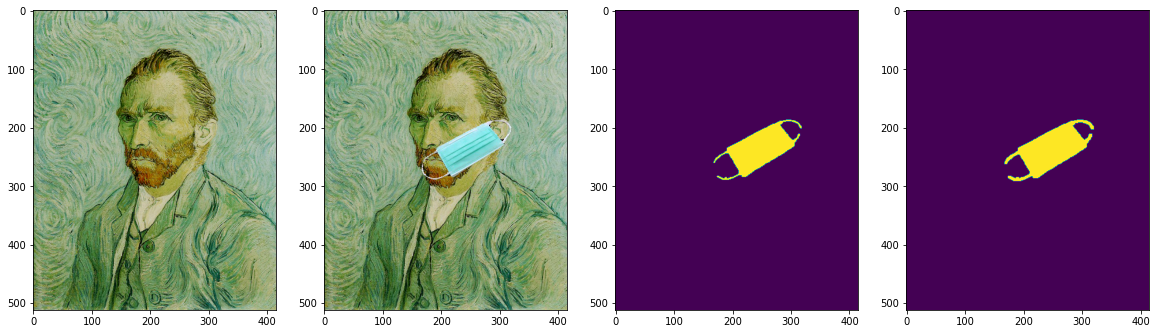

In [ ]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(20,10))
ax1.imshow(image_pure(style_img))
ax2.imshow(image_pure(content_img))
ax3.imshow(mask_img)
ax4.imshow(dilated_mask_img)
plt.show()

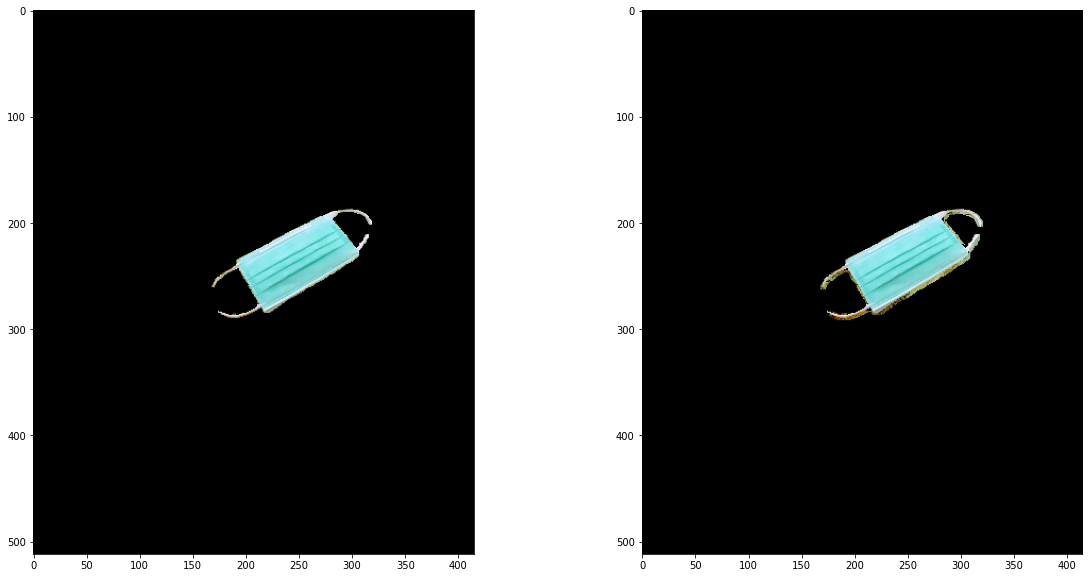

In [ ]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax1.imshow( image_pure(content_img) * mask_img[:,:,None])
ax2.imshow(dilated_mask_img[:,:,None] * image_pure(content_img))
plt.show()

In [ ]:
model = models.vgg16_bn(pretrained=True).features.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
def vgg_features(data,index=None):
    layers_index = {'2' : 'conv1_1', # 'layer' : 'layer_name'
                    '9' : 'conv2_1',
                    '16' : 'conv3_1',
                    '26' : 'conv4_1',
                    '29' : 'conv4_2',  ## content representation
                    '36' : 'conv5_1'}
    layers = index if index else layers_index  
    features={}
    for layer_index, layer in model._modules.items():
        data = layer(data)
        if layer_index in layers:
            features[layers_index[layer_index]]=data
    return features

In [ ]:
content_img_vggfeatures = vgg_features(content_img[None].to(device), index=['16','26','36'])
style_img_vggfeatures = vgg_features(style_img[None].to(device), index=['16','26','36'])

In [ ]:
[i.shape for i in content_img_vggfeatures.values()]


[torch.Size([1, 256, 128, 103]),
 torch.Size([1, 512, 64, 51]),
 torch.Size([1, 512, 32, 25])]

In [ ]:
class MaskFeatures(nn.Module):
    """
    change the dimension of the mask image by applying the AvgPool 
    corresponding to each convolutional layer of
    vgg model
    """
    
    def __init__(self):
        super().__init__()
        self.convol_mask = nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
    
    def apply_mask(self,data,loop):
        for j in range(loop):
            data = self.convol_mask(data)
        return data
   
    def forward(self,data):
        features=[]
        temp = [2,2,1,2,1,2,1]
        data = data[None,None,:,:]
        for k in temp:
            if k==1:
                data = self.convol_mask(data)
                features.append(data.squeeze().to(device))
            else:
#                 data = self.apply_mask(data,loop=k)
                data = F.interpolate(data, size=(data.shape[2]//2, data.shape[3]//2))
        return features

In [ ]:
extract_maskfeatures = MaskFeatures().to(device)
dilated_mask_imgfeatures = extract_maskfeatures((dilated_mask_img).float())

[torch.Size([128, 103]), torch.Size([64, 51]), torch.Size([32, 25])]


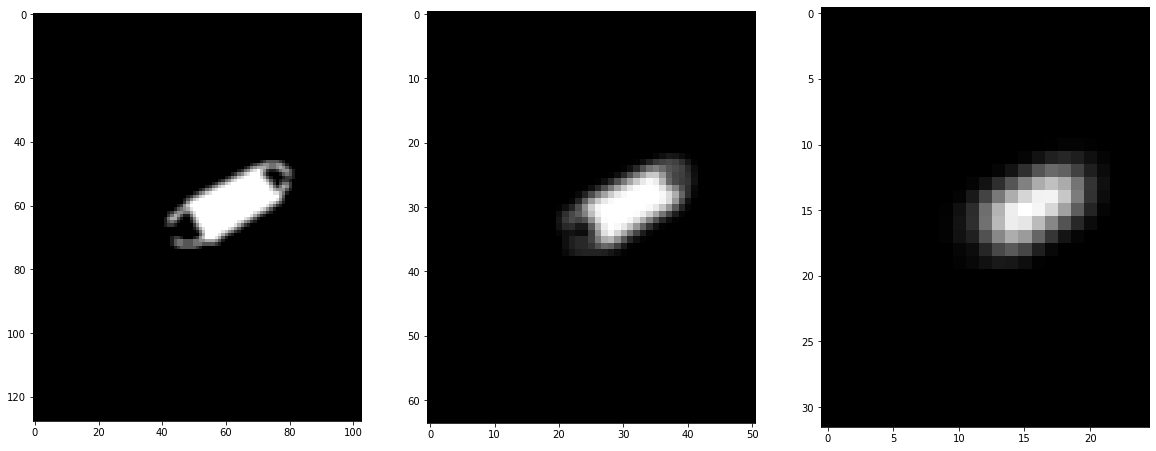

In [ ]:
print([i.shape for i in dilated_mask_imgfeatures])
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(20,10))
ax1.imshow((dilated_mask_imgfeatures[0].cpu()),cmap='gray')
ax2.imshow((dilated_mask_imgfeatures[1].cpu()),cmap='gray')
ax3.imshow((dilated_mask_imgfeatures[2].cpu()),cmap='gray')
plt.show()

# Mapping

In [ ]:
def get_patch(img, kernel_size=3 ,stride=1 ,padding=1):
    """
    returns the array of values by applying the filter of 
    kernel_size * kernel_size at each pixel of the image
    """
    patcher = nn.Unfold(kernel_size = kernel_size, padding=padding, stride=stride)
    patches = patcher(img)
    return patches.transpose(1,2).squeeze()

In [ ]:
def match_features(content_img, style_img):
    """
    Use the cosine similarity concept to find out how much
    two image patched look alike return the indexes
    """
    result = []
    for input_layerfeature, style_layerfeature in zip(content_img, style_img):
        
        input_layerpatch = get_patch(input_layerfeature)
        style_layerpatch = get_patch(style_layerfeature)
        
#         input_dot_style = input_layerpatch @ style_layerpatch.T
#         mod_input_layerpatch = torch.sqrt(torch.sum(input_layerpatch ** 2, 1)).unsqueeze(1)
#         mod_style_layerpatch = torch.sqrt(torch.sum(style_layerpatch ** 2 ,1)).unsqueeze(0)
#         down = (1e-15 + torch.mm(mod_input_layerpatch, mod_style_layerpatch))
#         cosine_similarity = input_dot_style / down
#         _, index = cosine_similarity.max(1)
        cosine = cosine_similarity(input_layerpatch.cpu(), style_layerpatch.cpu())
        index = np.argmax(cosine,1)        
        result.append(torch.tensor(index, device=device))
    return result

In [ ]:
%%time
content_mapped_stylefeatures = match_features(content_img_vggfeatures.values(), 
                                 style_img_vggfeatures.values())

CPU times: user 22.1 s, sys: 253 ms, total: 22.4 s
Wall time: 11.6 s


3 [torch.Size([13184]), torch.Size([3264]), torch.Size([800])]


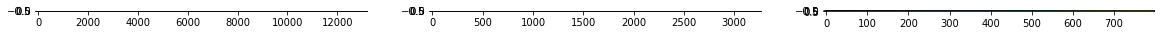

In [ ]:
print(len(content_mapped_stylefeatures),[i.shape for i in content_mapped_stylefeatures])
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(20,10))
ax1.imshow(content_mapped_stylefeatures[0].cpu().reshape(-1,13184))
ax2.imshow(content_mapped_stylefeatures[1].cpu().view(-1,3264),)
ax3.imshow(content_mapped_stylefeatures[2].cpu().view(-1,800),)
plt.show()

In [ ]:
def gram_mapped_style(mapped_index,imgfeatures, mask_features):
    result = []
    for index, layer, mask in zip(mapped_index, imgfeatures, mask_features):
        layer = layer.reshape(layer.shape[1],-1)
        layer = layer[:,index] * mask.view(1,-1)
        result.append(torch.tensor(layer @ layer.T))
    return result

In [ ]:
style_mappedGramContent = gram_mapped_style(content_mapped_stylefeatures, style_img_vggfeatures.values(),
                                            dilated_mask_imgfeatures)
[i.shape for i in style_mappedGramContent]

[torch.Size([256, 256]), torch.Size([512, 512]), torch.Size([512, 512])]

In [ ]:
def content_loss(imgfeature): 
    img_layer4_1 = imgfeature * dilated_mask_imgfeatures[1][None,None,:,:]
    content_layer4_1 = content_img_vggfeatures['conv4_1'] * dilated_mask_imgfeatures[1][None,None,:,:]
    return F.mse_loss(img_layer4_1, content_layer4_1, reduction='sum')/ float(imgfeature.shape[1] * dilated_mask_imgfeatures[1].sum())

def style_loss(imgfeatures):
    loss_val = 0
    for img_layer, gram_style_layer, mask_layer in zip(imgfeatures, style_mappedGramContent, dilated_mask_imgfeatures):
        
        img_layer = img_layer.reshape(img_layer.size(1),-1)        
        img_layer = img_layer * mask_layer.view(1,-1)

#         style_layer = style_layer * mask_layer.view(1,-1)
        
        gram_img_layer = img_layer @ img_layer.T
#         gram_style_layer = style_layer @ style_layer.T

        loss_val += F.mse_loss(gram_img_layer, gram_style_layer)
    return loss_val*10


# Reconstruction 1¶

In [ ]:
target_img = torch.tensor(content_img[None,:,:,:], requires_grad=True,device=device)

In [ ]:
def content_loss(imgfeature): 
    img_layer4_1 = imgfeature * dilated_mask_imgfeatures[1][None,None,:,:]
    content_layer4_1 = content_img_vggfeatures['conv4_1'] * dilated_mask_imgfeatures[1][None,None,:,:]
    return F.mse_loss(img_layer4_1, content_layer4_1, reduction='sum')/ float(imgfeature.shape[1] * dilated_mask_imgfeatures[1].sum())

def style_loss(imgfeatures):
    loss_val = 0
    for img_layer, gram_style_layer, mask_layer in zip(imgfeatures, style_mappedGramContent, dilated_mask_imgfeatures):
        
        img_layer = img_layer.reshape(img_layer.size(1),-1)        
        img_layer = img_layer * mask_layer.view(1,-1)

#         style_layer = style_layer * mask_layer.view(1,-1)
        
        gram_img_layer = img_layer @ img_layer.T
#         gram_style_layer = style_layer @ style_layer.T

        loss_val += F.mse_loss(gram_img_layer, gram_style_layer)
    return loss_val*10

In [ ]:
def total_loss(imgfeatures):
    content_loss_val = content_loss(imgfeatures[1])
    style_loss_val = style_loss(imgfeatures)
    total_loss = content_loss_val + style_loss_val
    global loop
    loop+=1
    if loop%100==0 or loop==1:
        print(f'{loop:>7d}{total_loss:>15.8f}{style_loss_val:>15.8f}{content_loss_val:>15.8f}')
    return total_loss

In [ ]:
%%time
optimizer = torch.optim.LBFGS([target_img], lr=1)
epoch = 1000
loop = 0
print(f'{"loop":>7}{"total_loss":>15}{"style_loss":>15}{"content_loss":>15}')
while loop<=epoch:
    def closure():
        optimizer.zero_grad()
        output = list(vgg_features(target_img, index=['16','26','36']).values())
        loss = total_loss(output)
        loss.backward()
        return loss
    optimizer.step(closure)
target_img = target_img.detach().squeeze()   

   loop     total_loss     style_loss   content_loss
      1    69.58280182    69.58280182     0.00000000
    100     1.30727053     1.30095959     0.00631090
    200     0.78883028     0.78224307     0.00658723
    300     0.63925141     0.63250035     0.00675107
    400     0.56462258     0.55772656     0.00689602
    500     0.52353871     0.51656103     0.00697768
    600     0.49607390     0.48903811     0.00703578
    700     0.47650459     0.46943334     0.00707126
    800     0.46118429     0.45408255     0.00710175
    900     0.44950059     0.44236392     0.00713668
   1000     0.43983108     0.43268096     0.00715012
CPU times: user 52.5 s, sys: 24.2 s, total: 1min 16s
Wall time: 1min 16s


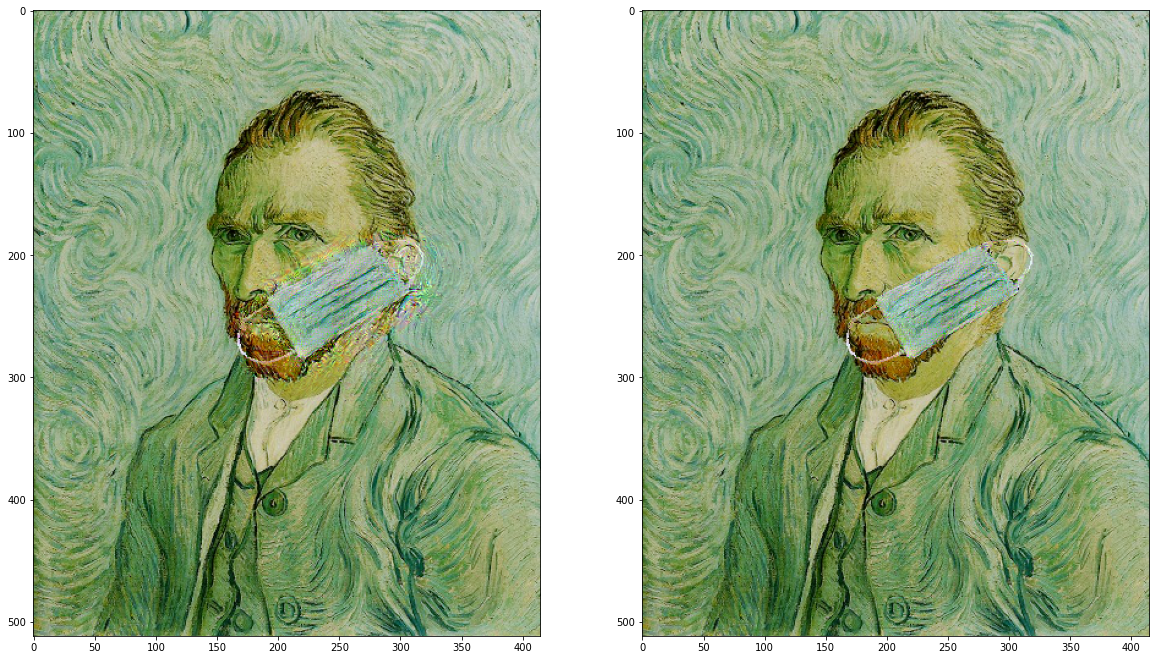

In [ ]:
phase1_img = (target_img.cpu()*mask_img + content_img*(1-mask_img)).squeeze()
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,20))
ax1.imshow(image_pure(target_img))
ax2.imshow(image_pure(phase1_img))
plt.show()

# Phase 2

In [ ]:
content_img_vggfeatures = vgg_features(content_img[None].to(device), index=['2','9','16','26'])
style_img_vggfeatures = vgg_features(style_img[None].to(device), index=['2','9','16','26'])
phase1_img_vggfeatures = vgg_features(phase1_img[None].to(device), index=['2','9','16','26'])

In [ ]:
[i.shape for i in phase1_img_vggfeatures.values()]


[torch.Size([1, 64, 512, 415]),
 torch.Size([1, 128, 256, 207]),
 torch.Size([1, 256, 128, 103]),
 torch.Size([1, 512, 64, 51])]

In [ ]:
class MaskFeatures2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.convol_mask = nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        
    def resize2half(self,data):
        return F.interpolate(data, size=(data.shape[2]//2, data.shape[3]//2))
    
    def forward(self,data):
        features=[]
        data = data[None,None,:,:]
        data = self.convol_mask(data)
        features.append(data.squeeze().to(device))
        data = self.resize2half(self.convol_mask(data))
        data = self.convol_mask(data)
        features.append(data.squeeze().to(device))
        data = self.resize2half(self.convol_mask(data))
        data = self.convol_mask(data)
        features.append(data.squeeze().to(device))
        data = self.convol_mask(data)
        data = self.resize2half(self.convol_mask(data))
        data = self.convol_mask(data)
        features.append(data.squeeze().to(device))
        return features

In [ ]:
dilated_mask_img.shape


torch.Size([512, 415])

In [ ]:
phase2_maskfeatures = MaskFeatures2()
dilated_mask_imgfeatures = phase2_maskfeatures(dilated_mask_img)

In [ ]:
[i.shape for i in dilated_mask_imgfeatures]


[torch.Size([512, 415]),
 torch.Size([256, 207]),
 torch.Size([128, 103]),
 torch.Size([64, 51])]

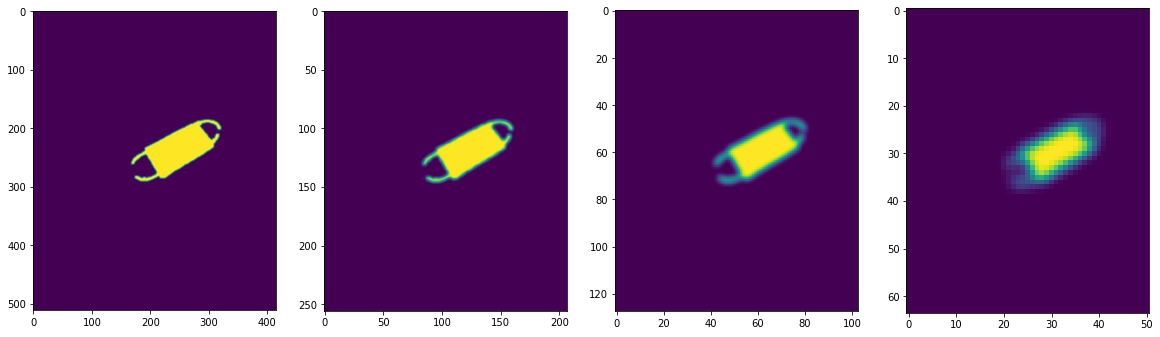

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,10))
for i in range(4):
    ax[i].imshow(dilated_mask_imgfeatures[i].detach().cpu())

In [ ]:
phase1imgfeatures_mapped_stylefeatures = match_features([list(phase1_img_vggfeatures.values())[-1]], 
                                                        [list(style_img_vggfeatures.values())[-1]])

In [ ]:
[i.shape for i in phase1imgfeatures_mapped_stylefeatures]


[torch.Size([3264])]

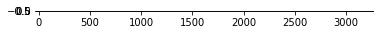

In [ ]:
plt.imshow(phase1imgfeatures_mapped_stylefeatures[0].reshape(-1,3264).cpu())


In [ ]:
conv4_1_size = style_img_vggfeatures['conv4_1'].shape
print(f'conv4_1_size: {conv4_1_size}')
style_img_resized = cv2.resize((image_pure(style_img)).numpy(), (conv4_1_size[-1], conv4_1_size[-2]))
style_img_resized = image_transform_vgg(style_img_resized).to(device)
style_img_resized.shape

conv4_1_size: torch.Size([1, 512, 64, 51])


torch.Size([3, 64, 51])

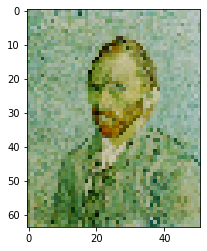

In [ ]:
plt.imshow(image_pure(style_img_resized))


In [ ]:
mask_img_resized = cv2.resize(mask_img.numpy(), (conv4_1_size[-1], conv4_1_size[-2]), interpolation=cv2.INTER_NEAREST)
mask_img_resized = torch.from_numpy(mask_img_resized).to(device)
mask_img_resized.shape

torch.Size([64, 51])

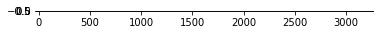

In [ ]:
plt.imshow(mask_img_resized.view(-1,3264).cpu())


In [ ]:
def neighbour_index(centered_index, neighbour, img_size):
    height,width = img_size
    co_ordinated_index = np.array([centered_index//width, centered_index%width]) + neighbour
    if 0<=co_ordinated_index[0]<height and 0<=co_ordinated_index[1]<width:
        return co_ordinated_index[0] * width + co_ordinated_index[1]
    else:
        return -1

In [ ]:
def phase2_match_features(mappedfeatures, style_features, mask, kernel_size=5):
    ch,height,width = style_features.shape
    mask = mask.view(-1) # 1-d array
    style_features = style_features.view(ch,-1).T
    result = mappedfeatures.clone()
    grid = [np.array([i,j]) for i in range(-(kernel_size//2),kernel_size//2+1)
                            for j in range(-(kernel_size//2),kernel_size//2+1)]
    for img_pixel in range(height*width):
        if mask[img_pixel]<=0.1:continue
        candidates = set()
        style_neighbour = []
        for pixel_cordinate in grid:
            to_index = neighbour_index(img_pixel, pixel_cordinate, (height, width))
            if to_index != -1:
                index_to = neighbour_index(mappedfeatures[to_index], -pixel_cordinate,(height, width))
                if index_to != -1:
                    candidates.add(index_to)
                    style_neighbour.append(index_to)
        candidates = torch.tensor([*candidates])
        if len(candidates)<=1:continue
        candiadate_features = np.take(style_features, candidates, axis=0)
        neighbour_features = np.take(style_features,style_neighbour ,axis=0)
        dists = (((candiadate_features[:,None] - neighbour_features[None])**2).sum(axis=2)).sum(axis=1)
        result[img_pixel] = candidates[dists.argmin()]
    return result

In [ ]:
mapped_phase2 = phase2_match_features(phase1imgfeatures_mapped_stylefeatures[0].cpu(),
                                      style_img_resized.cpu(), mask_img_resized.reshape(-1)).to(device)

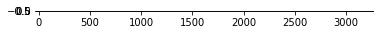

In [ ]:
plt.imshow(mapped_phase2.view(-1,3264).cpu())


In [ ]:
def upsample(mapped, orig_size, new_size):
    orig_height, orig_width = orig_size
    new_height, new_width = new_size
    TOTAL_NewMap_PIXEL = new_height * new_width
    new_map = torch.zeros(TOTAL_NewMap_PIXEL, dtype=torch.int32)#.to(device)
    scale_factor_height, scale_factor_width = new_height/orig_height, new_width/orig_width
    
    for map_pixel in range(TOTAL_NewMap_PIXEL):
        new_map_x_index , new_map_y_index = divmod(map_pixel, new_width)
        orig_x_index = min((0.5+new_map_x_index)//scale_factor_height, orig_height-1)
        orig_y_index = min((0.5+new_map_y_index)//scale_factor_width, orig_width-1)
        mapped_pixelIndex = mapped[int(orig_x_index*orig_width + orig_y_index)]
        
        mapped_x_index = int(new_map_x_index + (mapped_pixelIndex//orig_width - orig_x_index)*scale_factor_height + 0.5)
        mapped_y_index = int(new_map_y_index + (mapped_pixelIndex%orig_width - orig_y_index)*scale_factor_width + 0.5)
        
        mapped_x_index = min(mapped_x_index,new_height-1)
        mapped_y_index = min(mapped_y_index,new_width-1)
        
        new_map[map_pixel] = mapped_x_index*new_width + mapped_y_index
    return new_map

In [ ]:
%%time
mapped_features2 = [upsample(mapped_phase2, dilated_mask_imgfeatures[-1].shape, mask_layer.shape)
                    for mask_layer in dilated_mask_imgfeatures[:-1]] + [mapped_phase2]

CPU times: user 57.4 s, sys: 1.18 s, total: 58.5 s
Wall time: 58.5 s


In [ ]:
[i.shape for i in mapped_features2]


[torch.Size([212480]),
 torch.Size([52992]),
 torch.Size([13184]),
 torch.Size([3264])]

In [ ]:
mask_imgfeatures = [mask_img_resized]
for layer in list(style_img_vggfeatures.values())[-2::-1]:
    new_layer = cv2.resize((mask_imgfeatures[0].cpu()).numpy(), (layer.size(-1),layer.size(-2)), interpolation=cv2.INTER_NEAREST)
    mask_imgfeatures.insert(0,torch.tensor(new_layer).to(device))
[i.shape for i in mask_imgfeatures]

[torch.Size([512, 415]),
 torch.Size([256, 207]),
 torch.Size([128, 103]),
 torch.Size([64, 51])]

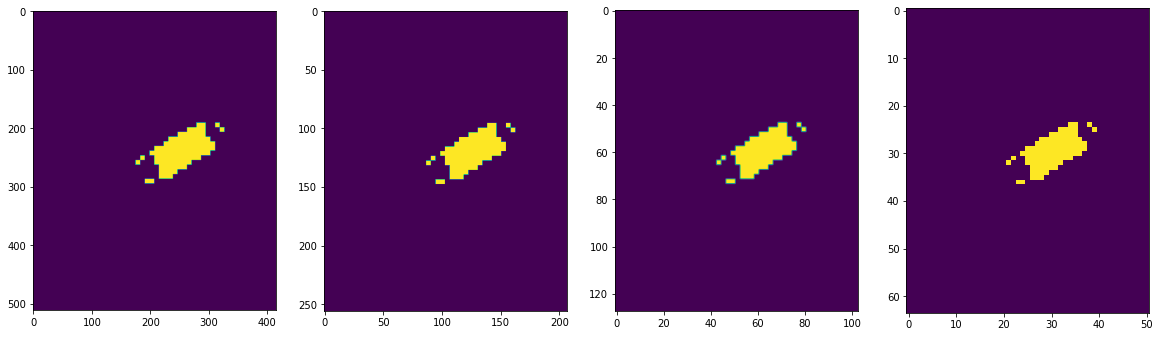

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,10))
for i in range(4):
    ax[i].imshow(mask_imgfeatures[i].cpu())

In [ ]:
def mapped_style2(style_features, map_features, mask_features):
    res=[]
    mask_=[]
    for style_ftr, map_ftr, mask_ftr in zip(style_features, map_features, mask_features):
        style_ftr = style_ftr.reshape(style_ftr.size(1),-1)
        mask_ftr = mask_ftr.reshape(-1)
        map_ftr = map_ftr.cpu().numpy()
        
        style_ftr = style_ftr[:,map_ftr]
        map_count = Counter(map_ftr)
        for index, pixel in enumerate(map_ftr):
            if mask_ftr[index] >=0.1 and map_count[pixel]>1:
                mask = (map_ftr==pixel)
                mask[index] = False
                mask_ftr[mask]=0
        res.append(style_ftr)
        mask_.append(mask_ftr)
        
    return res,mask_

In [ ]:
%%time
style_ftrs, mask_ftrs = mapped_style2(style_img_vggfeatures.values(), mapped_features2, mask_imgfeatures)

CPU times: user 12.9 s, sys: 698 ms, total: 13.6 s
Wall time: 13.6 s


In [ ]:
[i.shape for i in style_ftrs]


[torch.Size([64, 212480]),
 torch.Size([128, 52992]),
 torch.Size([256, 13184]),
 torch.Size([512, 3264])]

In [ ]:
def histogram_mask(style_features, mask_features):
    masked = style_features * mask_features
    return torch.cat([torch.histc(masked[i][mask_features>=0.1], n_bins).unsqueeze(0) 
    for i in range(masked.size(0))]).to(device)

In [ ]:
n_bins=256
style_hist_mask = [histogram_mask(style_ftrs[i],mask_ftrs[i]) for i in (0,3)]

In [ ]:
[i.shape for i in style_hist_mask]


[torch.Size([64, 256]), torch.Size([512, 256])]

In [ ]:
def style_loss(imgfeatures):
    loss_val=0
    for img_layer, style_layer, mask_layer, mask_resized_layer in zip(imgfeatures, style_ftrs, dilated_mask_imgfeatures, mask_ftrs):
        img_layer = img_layer.reshape(img_layer.size(1),-1)
        img_layer = img_layer * mask_layer.view(1,-1)

        style_layer = style_layer * mask_resized_layer[None].view(1,-1)
        style_layer = style_layer * float(torch.sqrt(mask_layer.sum()/mask_resized_layer.sum()))

        img_layer = img_layer @ img_layer.T
        style_layer = style_layer @ style_layer.T

        loss_val += F.mse_loss(img_layer, style_layer)
    return loss_val

def content_loss(imgfeature):
    img_layer4_1 = imgfeature * dilated_mask_imgfeatures[-1][None,None,:,:]
    content_layer4_1 = content_img_vggfeatures['conv4_1'] * dilated_mask_imgfeatures[-1][None,None,:,:]
    return F.mse_loss(img_layer4_1, content_layer4_1, reduction='sum')/ float(imgfeature.shape[1] * dilated_mask_imgfeatures[-1].sum())

In [ ]:
def select_index(tensor, index):
    channel = tensor.size(0)
    return tensor.view(-1)[index.view(-1)].view(channel,-1)

In [ ]:
def map_histogram(img, histogram_ref):
    channel, depth = img.size()
    sorted_img, sorted_index = img.sort(1)
    ymin, ymax = img.min(1)[0].unsqueeze(1), img.max(1)[0].unsqueeze(1)
    histogram_normalized = histogram_ref * depth / histogram_ref.sum(1).unsqueeze(1)
    cumsum_ref = histogram_normalized.cumsum(1) # cumulative sum https://pytorch.org/docs/stable/torch.html#torch.cumsum

    cumsum_previousIndex = torch.cat([torch.zeros(channel,1).to(device), cumsum_ref[:,:-1]], 1)
    step = (ymax - ymin)/256
    range_ = torch.arange(1,depth+1).unsqueeze(0).cuda()
    index = ((cumsum_ref.unsqueeze(1) - range_.unsqueeze(2))<0).sum(2).long()
    ratio = (range_ - select_index(cumsum_previousIndex, index))/(select_index(histogram_normalized, index)+ 1e-8)
    ratio = ratio.squeeze().clamp(0,1)

    new_x = ymin + (ratio + index.float() * step)
    _, remap = sorted_index.sort()
    new_x = select_index(new_x, index)
    return new_x

In [ ]:
def histogram_loss(imgfeatures):
    hist_loss = 0
    mask_features = [dilated_mask_imgfeatures[0], dilated_mask_imgfeatures[3]]
    for img_layer, mask_layer, style_hist_layer in zip(imgfeatures, mask_features, style_hist_mask):
        img_layer = img_layer.view(img_layer.size(1),-1)
        mask_layer = mask_layer.view(1,-1)
        img_layer = img_layer * mask_layer
        temp_mask = mask_layer>=0.1
        temp_mask = temp_mask[0,:]
        img_layer = torch.cat([layer[temp_mask].unsqueeze(0) for layer in img_layer])
        hist_loss = F.mse_loss(img_layer, map_histogram(img_layer, style_hist_layer))
    return hist_loss/2

In [ ]:
def total_variation_loss(imgfeatures):
    return ((imgfeatures[:,:-1,:] - imgfeatures[:,1:,:])**2).sum() + ((imgfeatures[:,:,:-1] - imgfeatures[:,:,1:])**2).sum()

In [ ]:
def median_total_variation_loss(img):
    channel,height, width = img.shape
    tensor1 = torch.cat([torch.zeros((channel,width))[:,None,:], img], axis=1)
    tensor2 = torch.cat([torch.zeros((channel,height))[:,:,None], img], axis=2)

    return torch.median((tensor1[:,:-1,:] - tensor1[:,1:,:]) ** 2 + (tensor2[:,:,:-1] - tensor2[:,:,1:]) ** 2)

In [ ]:
median_totalvariation_loss = median_total_variation_loss(style_img)
median_totalvariation_loss

tensor(0.1188)

In [ ]:
def final_loss(imgfeatures):
    content_loss_val = content_loss(imgfeatures[-1])
    style_loss_val = style_loss(imgfeatures)
    histogram_loss_val = histogram_loss([imgfeatures[0], imgfeatures[3]])
    total_variation_loss_val = total_variation_loss(imgfeatures[0])
    final_loss = content_loss_val + 0.01*style_loss_val + histogram_loss_val +\
                float(10 / (1 + torch.exp(median_totalvariation_loss * 10**4 -25)))*total_variation_loss_val
    global loop
    loop+=1
    if loop%100==0 or loop==1:
        print(f'{loop:>7d}{final_loss:>15.8f}{style_loss_val:>15.8f}{content_loss_val:>15.8f}{histogram_loss_val:>20.8f}{total_variation_loss_val:>25.8f}')
    return final_loss

In [ ]:
final_target_img = torch.tensor(phase1_img[None], requires_grad=True, device=device)

In [ ]:
%%time
optimizer = torch.optim.LBFGS([final_target_img],lr=0.1)
epoch = 1000
loop = 1
print(f'{"loop":>7}{"total_loss":>15}{"style_loss_val":>15}{"content_loss":>15}{"histogram_loss_val":>20}{"total_variation_loss_val":>25}')
while loop<=epoch:
    def closure():
        optimizer.zero_grad()
        output = vgg_features(final_target_img, index=['2','9','16','26'])
        output = list(output.values())
        loss = final_loss(output)
        loss.backward()
        return loss
    optimizer.step(closure)

   loop     total_loss style_loss_val   content_loss  histogram_loss_val total_variation_loss_val
    100     0.08948172     5.52468538     0.00612011          0.02811476         2626755.50000000
    200     0.05225046     1.88618588     0.00546552          0.02792308         2629818.50000000
    300     0.04484642     1.23902655     0.00474547          0.02771068         2633572.50000000
    400     0.04196718     1.01283550     0.00427775          0.02756107         2637483.75000000
    500     0.04054983     0.90592569     0.00402232          0.02746825         2641346.50000000
    600     0.03958822     0.83860219     0.00381645          0.02738575         2645254.50000000
    700     0.03891996     0.79120725     0.00367905          0.02732884         2648927.25000000
    800     0.03846679     0.75935245     0.00358971          0.02728356         2652179.50000000
    900     0.03809878     0.73586369     0.00349348          0.02724667         2655319.00000000
   1000     0.037791

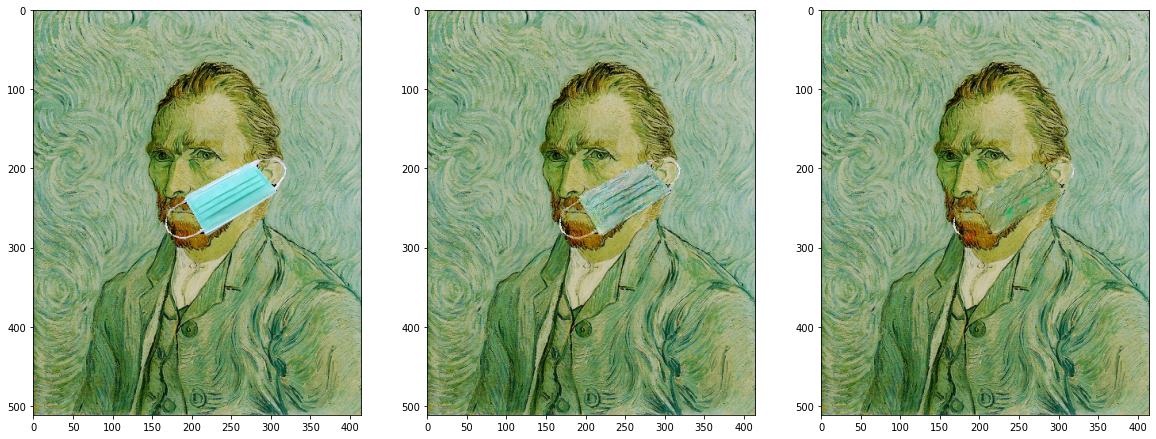

In [ ]:
final_img = final_target_img.detach().squeeze()
phase2_img = (final_img.cpu()*mask_img + content_img*(1-mask_img)).squeeze()

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(20,20))
ax1.imshow(image_pure(content_img))
ax2.imshow(image_pure(phase1_img))
ax3.imshow(image_pure(phase2_img))
plt.show()